# Trénovanie modelu iba na základe DST indexu 3h dopredu 6 dozadu
Súbor: 3_model_lstm_iba_dst.ipynb

Program: Hospodárska informatika

Vypracovala: Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

### Kontrola kapacity servera

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Import knižníc

In [42]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [43]:
df = pd.read_csv('omni_full.csv')
len(df)

520443

In [44]:
df.columns

Index(['Unnamed: 0', 'time1', 'Rot$', 'IMF', 'PLS', 'IMF_PTS', 'PLS_PTS',
       'ABS_B', 'F', 'THETA_AV', 'PHI_AV', 'BX_GSE', 'BY_GSE', 'BZ_GSE',
       'BY_GSM', 'BZ_GSM', 'SIGMA$ABS_B', 'SIGMA$B', 'SIGMA$Bx', 'SIGMA$By',
       'SIGMA$Bz', 'T', 'N', 'V', 'PHI$V', 'THETA$V', 'Ratio', 'Pressure',
       'SIGMA$T', 'SIGMA$N', 'SIGMA$V', 'SIGMA$PHI$V', 'SIGMA$THETA$V',
       'SIGMA$ratio', 'E', 'Beta', 'Mach_num', 'Mgs_mach_num', 'PR$FLX_1',
       'PR$FLX_2', 'PR$FLX_4', 'PR$FLX_10', 'PR$FLX_30', 'PR$FLX_60', 'MFLX',
       'R', 'F10_INDEX', 'KP', 'DST', 'AE', 'AP_INDEX', 'AL_INDEX', 'AU_INDEX',
       'PC_N_INDEX', 'Solar_Lyman_alpha', 'Proton_QI', 'DST+1', 'DST+2',
       'DST+3', 'DST+4', 'DST+6', 'DST+8', 'DST+12', 'DST+24'],
      dtype='object')

In [45]:
features = ['time1',
           'DST',
            'DST+3']

In [46]:
df = df[features]

In [47]:
df['time1']=pd.to_datetime(df['time1'])

In [48]:
df.dropna(inplace=True)
print(len(df))

520440


In [49]:
predicted_label = 'DST+3'

In [50]:
df.describe()

,DST,DST+3
count,520440.000000,520440.000000
mean,-14.125071,-14.125123
std,22.034884,22.034850
min,-589.000000,-589.000000
25%,-22.000000,-22.000000
50%,-10.000000,-10.000000
75%,-1.000000,-1.000000
max,81.000000,81.000000


In [51]:
df[predicted_label].describe()

count    520440.000000
mean        -14.125123
std          22.034850
min        -589.000000
25%         -22.000000
50%         -10.000000
75%          -1.000000
max          81.000000
Name: DST+3, dtype: float64

In [52]:
df.head()

,time1,DST,DST+3
3,1963-01-01 04:00:00,-3.0,-5.0
4,1963-01-01 05:00:00,-6.0,-5.0
5,1963-01-01 06:00:00,-8.0,-3.0
6,1963-01-01 07:00:00,-9.0,-3.0
7,1963-01-01 08:00:00,-6.0,-6.0


<AxesSubplot:>

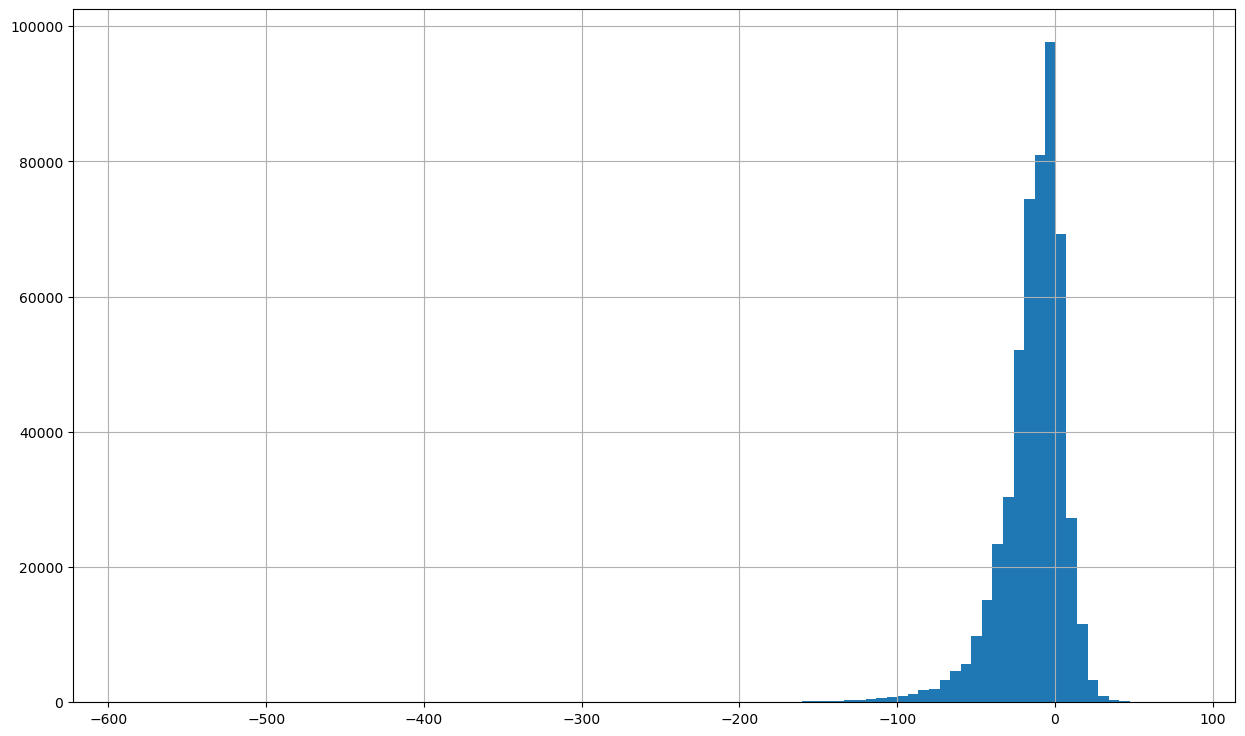

In [53]:
df[predicted_label].hist(bins=100)

In [54]:
# transform label using sigmoid
variance = df[predicted_label].std()
df["contcontinuous_transforminuous_transform"] = df[predicted_label].apply(lambda x: expit(2 * ((x - 0.2) / variance)))
df["contcontinuous_transforminuous_transform"].describe()

count    5.204400e+05
mean     3.113690e-01
std      2.271203e-01
min      5.948401e-24
25%      1.176380e-01
50%      2.837763e-01
75%      4.727973e-01
max      9.993474e-01
Name: contcontinuous_transforminuous_transform, dtype: float64

In [55]:
# choose one of them
# define y variable, i.e., what we want to predict

y_col='DST+3'
#y_col='contcontinuous_transforminuous_transform'

In [56]:
# train-test division

test_size = int(len(df) * 0.2) # here I ask that the test data will be 20% of the entire data
train = df.iloc[:-test_size,:].copy()
test = df.iloc[-test_size:,:].copy()

In [57]:
# train-validation division

valid_size = int(len(train) * 0.2) # here I ask that the test data will be 15% of the entire data
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

In [58]:
# separate features and labels

y_train = train[y_col].values.copy()
X_train = train['DST'].values.copy()

y_val = valid[y_col].values.copy()
X_val = valid['DST'].values.copy()

y_test = test[y_col].values.copy()
X_test = test['DST'].values.copy()

In [59]:
print(y_test[0:40])

[ -9. -12. -13. -13. -12. -12. -17. -17. -15. -11.  -8. -12. -16. -14.
 -14. -14. -15. -17. -13. -15. -24. -21. -17. -15. -17. -25. -27. -26.
 -27. -27. -25. -26. -20. -16. -14. -14. -16. -16. -15. -13.]


In [60]:
len(y_test)

104088

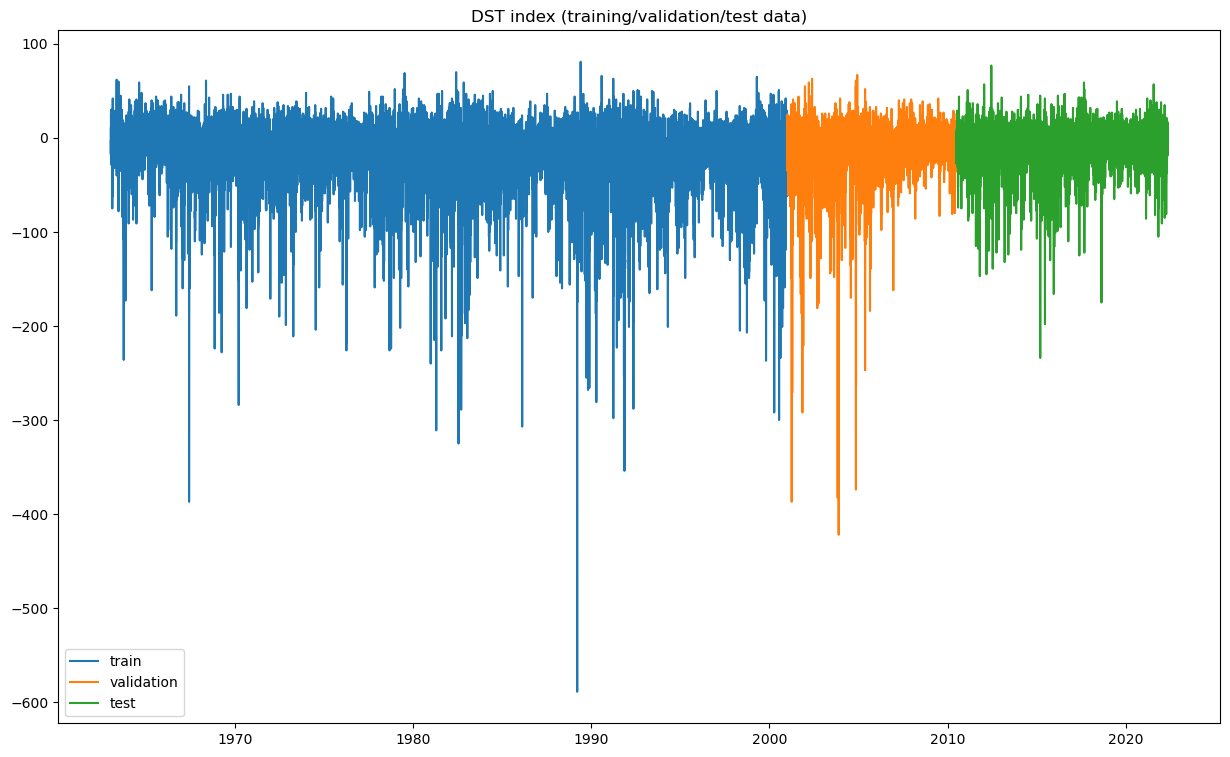

In [61]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [62]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [24]:
for i in range(len(test_generator)):
	x, y = test_generator[i]
	print('tt %s => %s' % (x, y))

tt [[-13. -12. -12. -17. -17. -15.]
 [-12. -12. -17. -17. -15. -11.]
 [-12. -17. -17. -15. -11.  -8.]
 ...
 [ -7.  -4.  -2.  -3.  -5.  -6.]
 [ -4.  -2.  -3.  -5.  -6.  -4.]
 [ -2.  -3.  -5.  -6.  -4.  -5.]] => [-17. -17. -15. -11.  -8. -12. -16. -14. -14. -14. -15. -17. -13. -15.
 -24. -21. -17. -15. -17. -25. -27. -26. -27. -27. -25. -26. -20. -16.
 -14. -14. -16. -16. -15. -13. -10. -15. -18. -21. -22. -18. -14. -15.
 -18. -19. -19. -16. -16. -17. -17. -15. -18. -15. -13. -12. -10. -14.
 -16. -16. -12. -10.  -9.  -9. -13. -17. -16. -21. -21. -19. -19. -17.
 -17. -19. -18. -19. -18. -16. -16. -16. -16. -14. -11.  -7.  -6. -11.
 -19. -22. -21. -18. -15. -13. -15. -13. -13. -12. -12.  -9. -10. -11.
 -14. -13. -12.  -8.  -4.  -1.  -1.  -1.  -4.  -6.  -9. -12. -12. -15.
 -19. -21. -18. -16. -12. -12. -11. -12. -15. -17. -17. -15. -14. -13.
  -9.  -8.  -9.  -9.  -8.  -5.  -3.  -5.  -7.  -9. -12. -10. -11. -12.
 -11.  -9.  -9.  -8.  -9. -11. -10.  -8.  -3.  -3.  -3.   0.  -2.  -5.
  -6.  -5

In [63]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1302
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [64]:
inputs = Input(shape=(n_input,1))
b = Conv1D(128, kernel_size = 4, padding = "same")(inputs)
b = Bidirectional(LSTM(128, dropout=0.1,recurrent_dropout=0.1))(inputs)
b = Dense(64, activation='relu')(b)
b = Dropout(0.2)(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              133120    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                           

In [65]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 6, 256)           133120    
 nal)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed_1 (TimeDis  (None, 6, 1)             129       
 tributed)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 6)                 0         
                                                                 
 dense_9 (Dense)             (None, 1)                 7   

In [66]:
# callbacks
saved_model = "6_dozadu_3_dopredu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [67]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20
1302/1302 [==============================] - ETA: 0s - loss: 71.4207 - mae: 2.5589
Epoch 1: val_mae improved from inf to 2.29149, saving model to 6_dozadu_3_dopredu.hdf5
1302/1302 [==============================] - 100s 72ms/step - loss: 71.4207 - mae: 2.5589 - val_loss: 35.9771 - val_mae: 2.2915
Epoch 2/20
1302/1302 [==============================] - ETA: 0s - loss: 12.0402 - mae: 1.2538
Epoch 2: val_mae improved from 2.29149 to 1.08553, saving model to 6_dozadu_3_dopredu.hdf5
1302/1302 [==============================] - 93s 71ms/step - loss: 12.0402 - mae: 1.2538 - val_loss: 13.6787 - val_mae: 1.0855
Epoch 3/20
1302/1302 [==============================] - ETA: 0s - loss: 8.2615 - mae: 1.1993
Epoch 3: val_mae did not improve from 1.08553
1302/1302 [==============================] - 92s 71ms/step - loss: 8.2615 - mae: 1.1993 - val_loss: 11.4507 - val_mae: 1.2691
Epoch 4/20
1302/1302 [==============================] - ETA: 0s - loss: 7.1702 - mae: 1.1228
Epoch 4: val_mae did 

In [68]:
# load best model
model = keras.models.load_model('6_dozadu_3_dopredu.hdf5')

In [69]:
# prediction
y_pred = model.predict(test_generator)

407/407 [==============================] - 9s 19ms/step


In [70]:
y_pred

array([[-15.3213625],
       [-15.735239 ],
       [-13.628651 ],
       ...,
       [  2.0692565],
       [  1.6836867],
       [  3.6294315]], dtype=float32)

In [71]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[83348    18]
 [ 2980 17736]]


In [72]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     83366
           1       1.00      0.86      0.92     20716

    accuracy                           0.97    104082
   macro avg       0.98      0.93      0.95    104082
weighted avg       0.97      0.97      0.97    104082



In [73]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [74]:
df

,time,y_true,y_predict
416361,2010-06-29 11:00:00,-17.0,-15.321362
416362,2010-06-29 12:00:00,-17.0,-15.735239
416363,2010-06-29 13:00:00,-15.0,-13.628651
416364,2010-06-29 14:00:00,-11.0,-10.072916
416365,2010-06-29 15:00:00,-8.0,-8.206242
...,...,...,...
520438,2022-05-13 12:00:00,8.0,8.174789
520439,2022-05-13 13:00:00,6.0,5.285316
520440,2022-05-13 14:00:00,2.0,2.069257
520441,2022-05-13 15:00:00,2.0,1.683687


In [75]:
df.describe()

,y_true,y_predict
count,104082.000000,104082.000000
mean,-9.641340,-9.156361
std,16.040007,15.158597
min,-234.000000,-191.259766
25%,-17.000000,-15.322181
50%,-7.000000,-6.707341
75%,0.000000,0.119052
max,77.000000,62.873924


<AxesSubplot:>

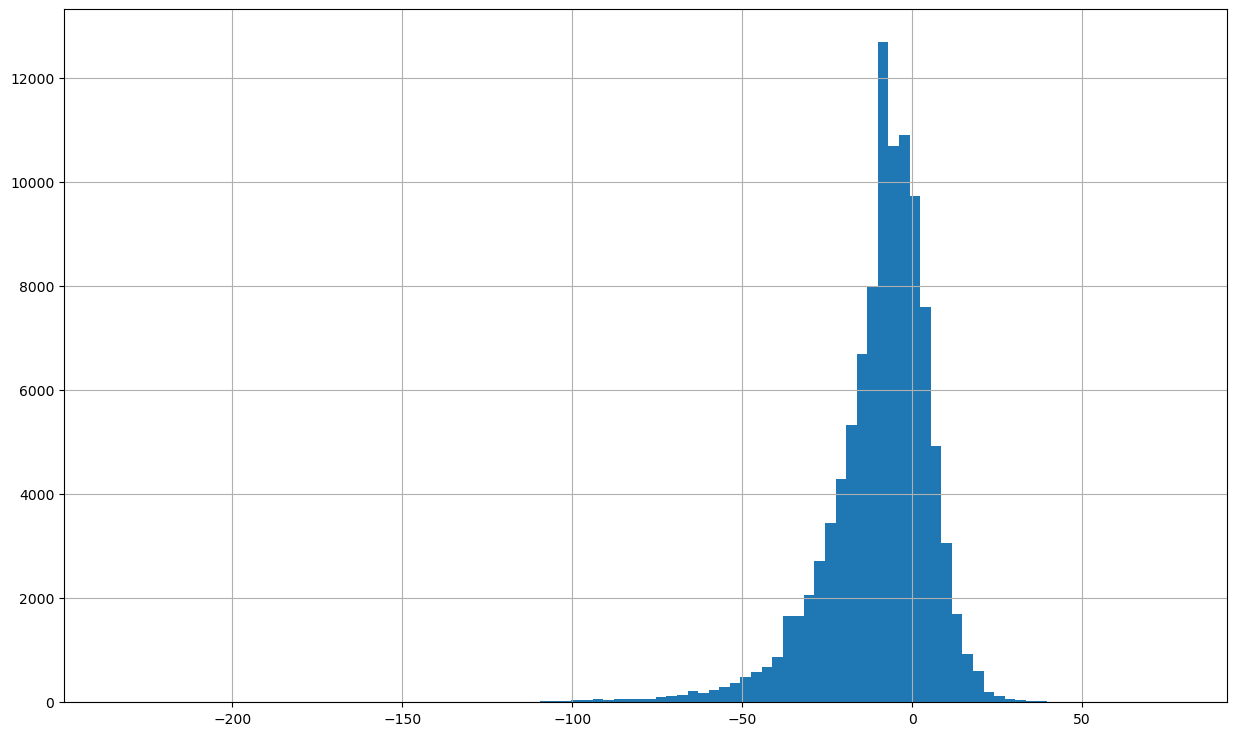

In [76]:
df["y_true"].hist(bins=100)

<AxesSubplot:>

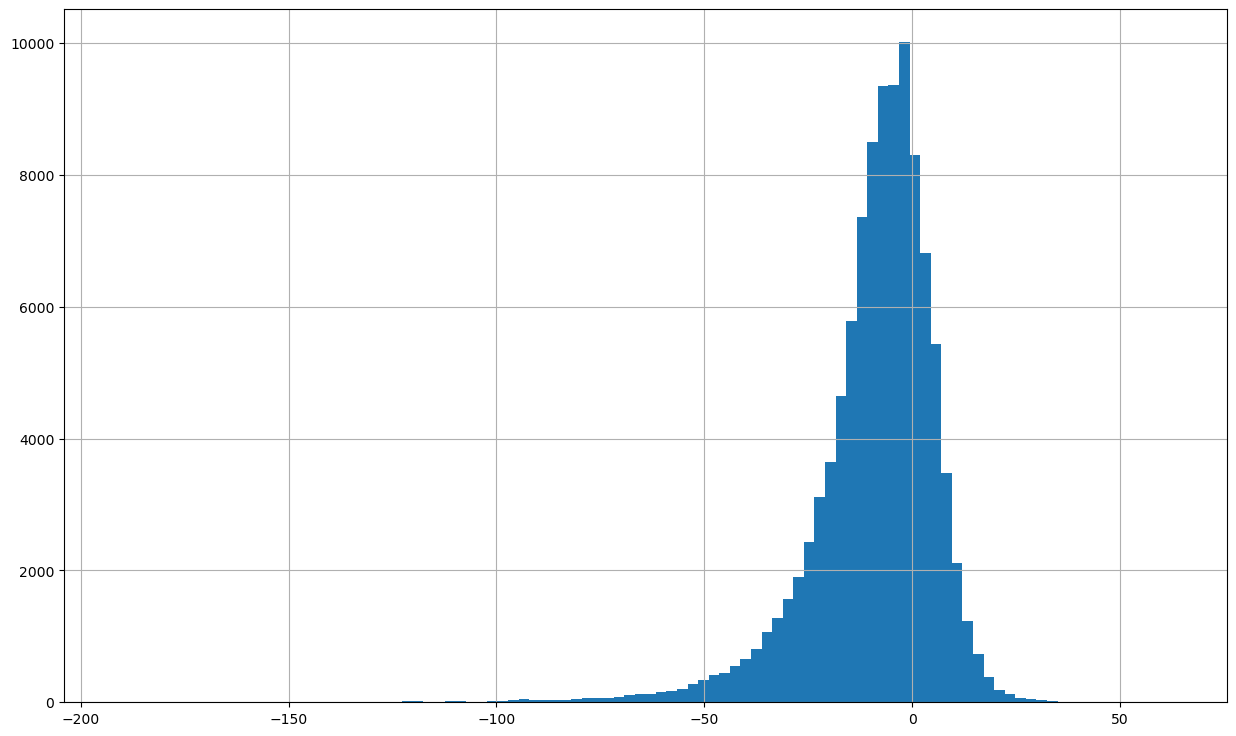

In [77]:
df["y_predict"].hist(bins=100)

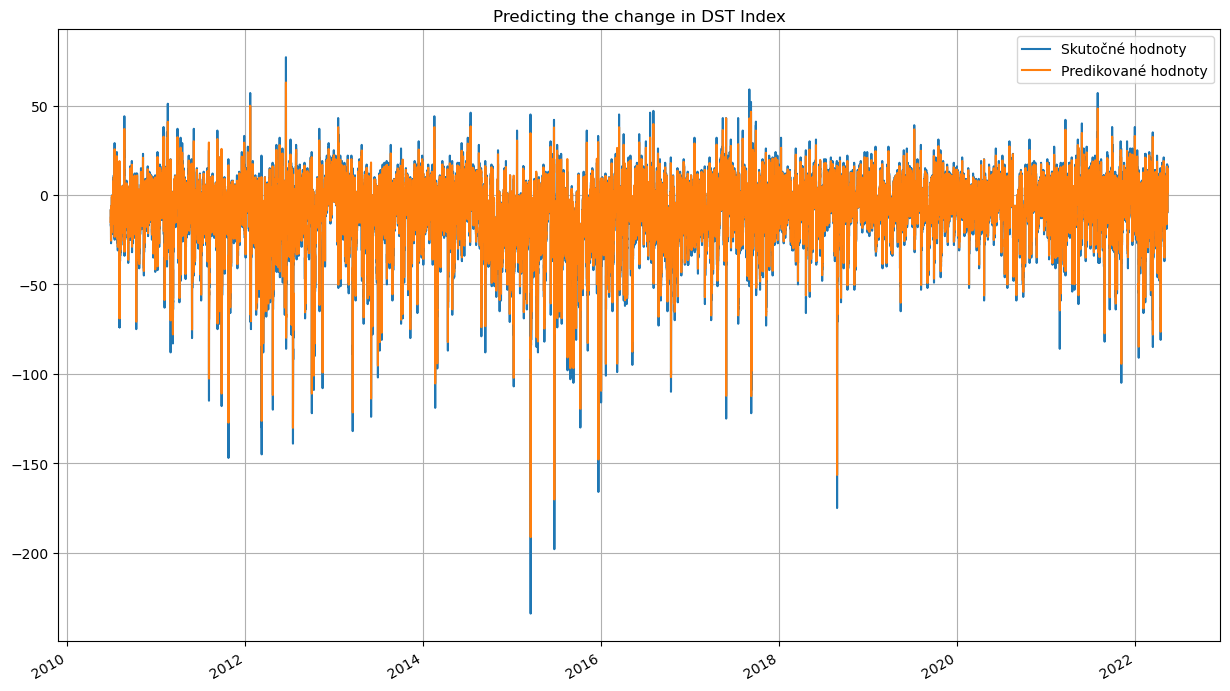

In [78]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [79]:
df.to_csv('predikcie_6h_dozadu_3h_dopredu.csv')